This is the final Scirpt to get the required accuracy of 99.4%

# Target

1. Fix the Learning Rate to get the higher accuracy


# Result
1. Params: 9,910
2. Best Train Accuracy: 98.96%
3. Best Test Accuracy : 99.44% in 9th epoch but then reduced to 99.40% from epoch 12 onwards

# Analysis
* The model is underfitting. This is because the training is very hard . there is a rotation of images and the number of parameters is very less

* The real improvement is the use of Scheduler with StepLR. This will start a high Leraning rate so that the model starts learning fast and then drops the LR to smaller rates making the fine adjustments. This is seen in the last epochs where the training accuracy is not changing much.
* The test accuracy is stable


# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations



In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [ ]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=28, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(28),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 28, 24, 24]           3,528
              ReLU-6           [-1, 28, 24, 24]               0
       BatchNorm2d-7           [-1, 28, 24, 24]              56
           Dropout-8           [-1, 28, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             336
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,512
             ReLU-12           [-1, 14, 10, 10]               0

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=15)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    #print("LR:",optimizer.param_groups[0]['lr'])
    print('LR:', scheduler.get_last_lr())
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

EPOCH: 0
LR: [0.3]


Loss=0.13461896777153015 Batch_id=468 Accuracy=93.10: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]



Test set: Average loss: 0.1129, Accuracy: 9653/10000 (96.53%)

EPOCH: 1
LR: [0.3]


Loss=0.07959108054637909 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:20<00:00, 23.31it/s]



Test set: Average loss: 0.0510, Accuracy: 9851/10000 (98.51%)

EPOCH: 2
LR: [0.3]


Loss=0.037569936364889145 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]



Test set: Average loss: 0.0372, Accuracy: 9886/10000 (98.86%)

EPOCH: 3
LR: [0.3]


Loss=0.023318113759160042 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:17<00:00, 27.00it/s]



Test set: Average loss: 0.0379, Accuracy: 9877/10000 (98.77%)

EPOCH: 4
LR: [0.3]


Loss=0.06285042315721512 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]



Test set: Average loss: 0.0267, Accuracy: 9915/10000 (99.15%)

EPOCH: 5
LR: [0.3]


Loss=0.02675520069897175 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:17<00:00, 26.96it/s]



Test set: Average loss: 0.0289, Accuracy: 9907/10000 (99.07%)

EPOCH: 6
LR: [0.03]


Loss=0.010217396542429924 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s]



Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 7
LR: [0.03]


Loss=0.007660293485969305 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]



Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 8
LR: [0.03]


Loss=0.06987547129392624 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]



Test set: Average loss: 0.0200, Accuracy: 9944/10000 (99.44%)

EPOCH: 9
LR: [0.03]


Loss=0.018518097698688507 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]



Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 10
LR: [0.03]


Loss=0.01401657983660698 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s]



Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 11
LR: [0.03]


Loss=0.007333265617489815 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]



Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 12
LR: [0.003]


Loss=0.04188038036227226 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:18<00:00, 25.11it/s]



Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 13
LR: [0.003]


Loss=0.011349081061780453 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 27.26it/s]



Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 14
LR: [0.003]


Loss=0.06713584810495377 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:17<00:00, 26.69it/s]



Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)



## Plotting the Results

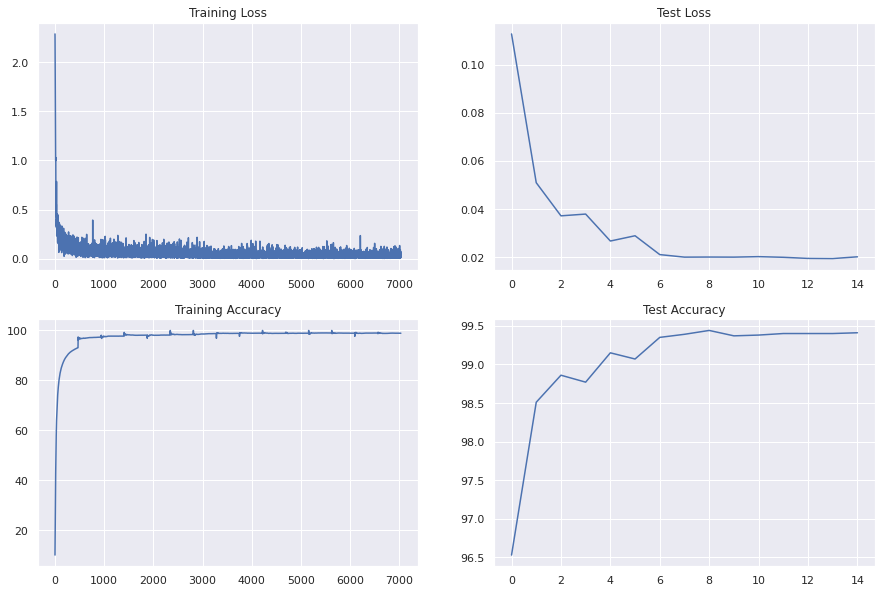

In [ ]:

## first bdirn the data to the cpu
import numpy as np
t=[t.cpu().item() for t in train_losses]



import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()
     